In [12]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

In [13]:
insurance = pd.read_csv("/content/before_Obamacare.csv")

In [14]:
insurance.shape

(864529, 8)

> Drop the year variable

In [15]:
# Drop the 'YEAR' variable
insurance = insurance.drop(columns=["YEAR"])

In [16]:
insurance.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
0,1,100.0,30.0,1.0,1.0,0,0
1,2,100.0,30.0,1.0,1.0,1,25
2,2,100.0,30.0,1.0,1.0,0,0
3,1,100.0,30.0,1.0,1.0,0,0
4,1,100.0,30.0,1.0,1.0,0,0


## Matching

In [17]:
# Convert all columns to integer type
insurance = insurance.astype(int)

In [18]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame:")
print(insurance.dtypes)

Data types of each variable in the DataFrame:
SEX                int64
RACENEW            int64
INCFAM97ON2        int64
HINOTCOVE          int64
CNLUNG             int64
SMK                int64
Occupation_Code    int64
dtype: object


In [19]:
# Map 1 to 1 and 2 to 0 in the "HINOTCOVE" column
insurance["HINOTCOVE"] = insurance["HINOTCOVE"].map({1: 1, 2: 0})

# Check unique values in the "HINOTCOVE" column after mapping
unique_values = insurance["HINOTCOVE"].unique()
print(unique_values)

[1 0]


In [20]:
# Map 1 to 0 and 2 to 1 in the "CNLUNG" column
insurance["CNLUNG"] = insurance["CNLUNG"].map({1: 0, 2: 1})

# Check unique values in the "CNLUNG" column after mapping
unique_values = insurance["CNLUNG"].unique()
print(unique_values)

[0 1]


In [21]:
import dame_flame

model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result = model.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  2404
	Unmatched treated units:  7981 out of a total of  715323 treated units
	Unmatched control units:  265 out of a total of  149206 control units
	Number of matches made this iteration:  856283
	Number of matches made so far:  856283
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.0011094063618850133
Completed iteration 1 of matching
	Number of matched groups formed in total:  2456
	Unmatched treated units:  7883 out of a total of  715323 treated units
	Unmatched control units:  199 out of a total of  149206 control units
	Number of matches made this iteration:  164
	Number of matches made so far:  856447
	Covariates dropped so far:  frozenset({'SEX'})
	Predictive error of covariate set used to match:  0.0011094220509492226
Completed iteration 2 of matching
	Number of matched groups formed in total:  2546
	Unmatched treated units:  7544 out of a total of  715323 treat

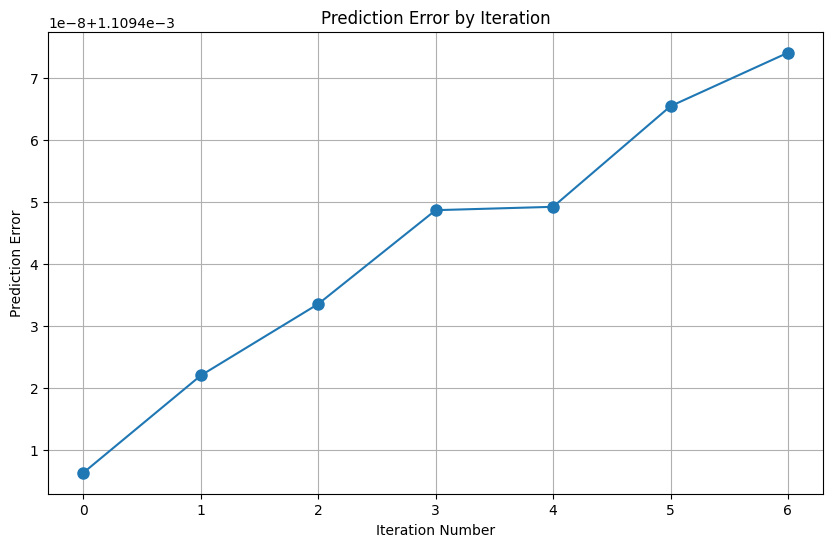

In [22]:
# Retrieve the prediction errors for each iteration
prediction_errors = model.pe_each_iter

# Plotting the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, marker="o", linestyle="-", markersize=8)
plt.title("Prediction Error by Iteration")
plt.xlabel("Iteration Number")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

> I choose my stopping point at iteration number 1.

In [24]:
model_new = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=0,  # Stop after iteration 1
)
model_new.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result_new = model_new.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  2404
	Unmatched treated units:  7981 out of a total of  715323 treated units
	Unmatched control units:  265 out of a total of  149206 control units
	Number of matches made this iteration:  856283
	Number of matches made so far:  856283
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.0011094063618850133
856283 units matched. We stopped after iteration 0


In [25]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [26]:
matched_data = get_dataframe(model_new, result_new)
matched_data.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code,match_group,match_group_size,weights
0,1,100,30,1,0,0,0,463.0,36124.0,1.0
1,2,100,30,1,0,1,25,551.0,137.0,1.0
2,2,100,30,1,0,0,0,464.0,34036.0,1.0
3,1,100,30,1,0,0,0,463.0,36124.0,1.0
4,1,100,30,1,0,0,0,463.0,36124.0,1.0


In [27]:
matched_data.shape

(856283, 10)

In [28]:
print(f"Checking the Columns in matched data:")
matched_data.columns

Checking the Columns in matched data:


Index(['SEX', 'RACENEW', 'INCFAM97ON2', 'HINOTCOVE', 'CNLUNG', 'SMK',
       'Occupation_Code', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [29]:
# Model with controls except County
model_with_controls = smf.wls(
    "CNLUNG ~ HINOTCOVE + C(SEX) + C(RACENEW) + C(INCFAM97ON2) + C(SMK) + C(Occupation_Code)",
    data=matched_data,
    weights=matched_data["weights"],
).fit()

In [30]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 CNLUNG   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     87.79
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:53:21   Log-Likelihood:             1.8243e+06
No. Observations:              856283   AIC:                        -3.648e+06
Df Residuals:                  856233   BIC:                        -3.648e+06
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0005      0.000     -3.712      0.000      -0.001      -0.000
C(SEX)[T.2]                 -0.0001   6.28e-05     -2.309      0.021      -0.000   -2.19e-05
C(RACENEW)[T.200]           -0.0002    8.8e-05     -2.721      0.007      -0.000    -6.7e-05
C(RACENEW)[T.300]           -0.0001      0.000     -0.317      0.752      -0.001       0.001
C(RACENEW)[T.400]           -0.0002      0.000     -1.365      0.172      -0.000    8.85e-05
C(RACENEW)[T.520]           -0.0004      0.000     -1.599      0.110      -0.001    9.05e-05
C(RACENEW)[T.530]           -0.0002      0.001     -0.221      0.825      -0.002       0.002
C(RACENEW)[T.541]           -0.0003      0.000     -1.277      0.202      -0.001       0.000
C(INCFAM97ON2)[T.10]         0.0003      0.000      3.063      0.002       0.000       0.001
C(INCFAM97ON2)[T.20]        -0.0002      0.000     -1.368      0.171      -0.000    6.76e-05
C(INCFAM97ON2)[T.30]        -0.0003      0.000     -2.144      0.032      -0.001   -2.31e-05
C(INCFAM97ON2)[T.31]        -0.0004      0.000     -1.807      0.071      -0.001    3.07e-05
C(INCFAM97ON2)[T.32]        -0.0003      0.000     -1.823      0.068      -0.001    2.28e-05
C(INCFAM97ON2)[T.96]      -1.09e-05      0.000     -0.082      0.934      -0.000       0.000
C(SMK)[T.1]                  0.0074      0.000     52.403      0.000       0.007       0.008
C(SMK)[T.2]                  0.0029      0.000     21.499      0.000       0.003       0.003
C(Occupation_Code)[T.1]     -0.0018      0.000     -7.866      0.000      -0.002      -0.001
C(Occupation_Code)[T.2]     -0.0021      0.000     -6.950      0.000      -0.003      -0.001
C(Occupation_Code)[T.3]     -0.0025      0.000     -9.367      0.000      -0.003      -0.002
C(Occupation_Code)[T.4]     -0.0004      0.000     -1.243      0.214      -0.001       0.000
C(Occupation_Code)[T.5]     -0.0023      0.000     -7.180      0.000      -0.003      -0.002
C(Occupation_Code)[T.6]     -0.0022      0.000     -7.213      0.000      -0.003      -0.002
C(Occupation_Code)[T.7]     -0.0023      0.000     -6.088      0.000      -0.003      -0.002
C(Occupation_Code)[T.8]     -0.0014      0.000     -3.364      0.001      -0.002      -0.001
C(Occupation_Code)[T.9]     -0.0021      0.000     -5.244      0.000      -0.003      -0.001
C(Occupation_Code)[T.10]    -0.0003      0.000     -0.668      0.504      -0.001       0.001
C(Occupation_Code)[T.11]    -0.0031      0.000     -7.466      0.000      -0.004      -0.002
C(Occupation_Code)[T.12]    -0.0024      0.000     -5.240      0.000      -0.003      -0.002
C(Occupation_Code)[T.13]    -0.0026      0.000     -5.649      0.000      -0.004      -0.002
C(Occupation_Code)[T.14]    -0.0036      0.000     -7.169      0.000      -0.005      -0.003
C(Occupation_C

In [31]:
# To get the coefficient for the 'HINOTCOVE' variable
insurance_coefficient_control = model_with_controls.params["HINOTCOVE"]
print(f"Coefficient for 'HINOTCOVE' with controls: {insurance_coefficient_control:.4f}")

Coefficient for 'HINOTCOVE' with controls: 0.0008


In [32]:
# To get the p-value for the coefficient of 'HINOTCOVE' variable
insurance_p_value_control = model_with_controls.pvalues["HINOTCOVE"]
print(f"P-value for 'HINOTCOVE' with controls: {insurance_p_value_control:.4f}")

P-value for 'HINOTCOVE' with controls: 0.0000


>- Coefficient (0.0130): This indicates that, on average, individuals with insurance coverage (compared to those without coverage) have a 0.0130 increase in the log-odds of being diagnosed with lung cancer, holding all other variables constant. Individuals with insurance coverage are estimated to have a 0.0130 higher likelihood of being diagnosed with lung cancer compared to those without coverage, after accounting for other factors.
>- The p-value is less than the conventional threshold of 0.05, suggesting that the estimated effect of insurance coverage on lung cancer diagnosis is statistically significant.
>- There is evidence to support the hypothesis that having insurance coverage increases the likelihood of lung cancer diagnosis, after controlling for other covariates and potential confounders.